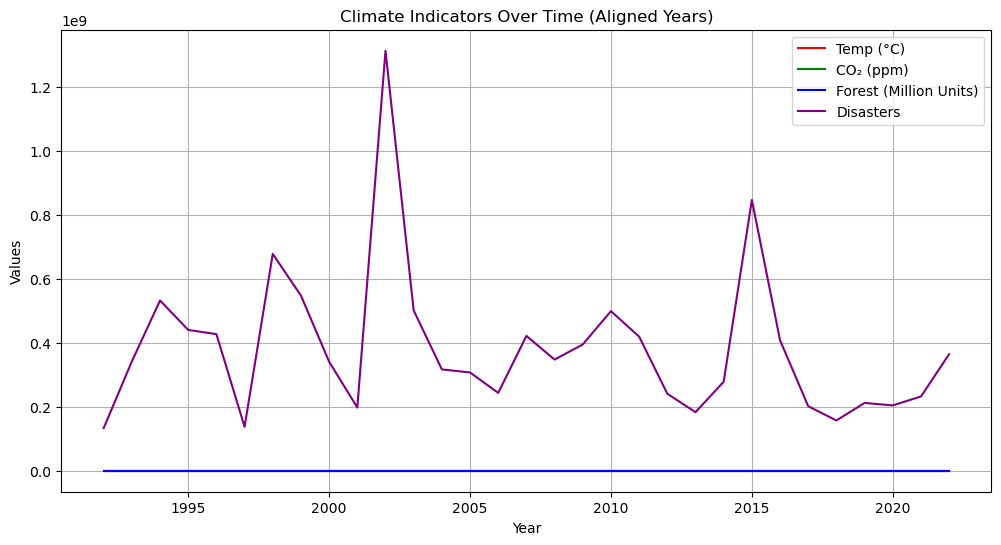

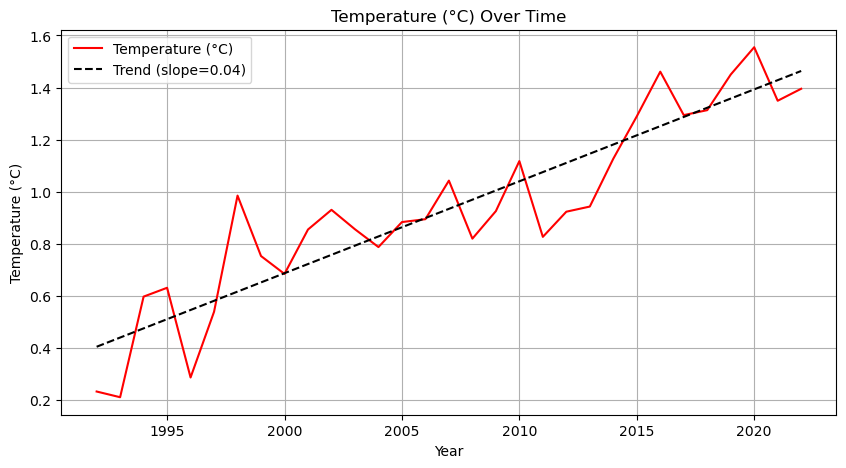

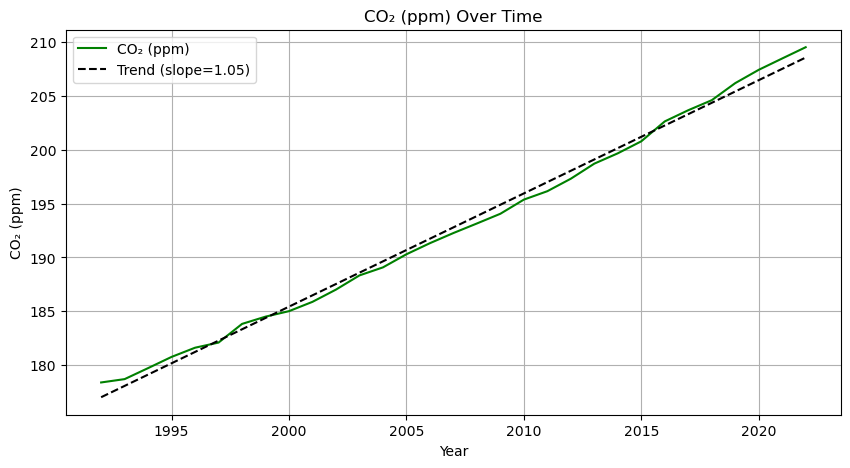

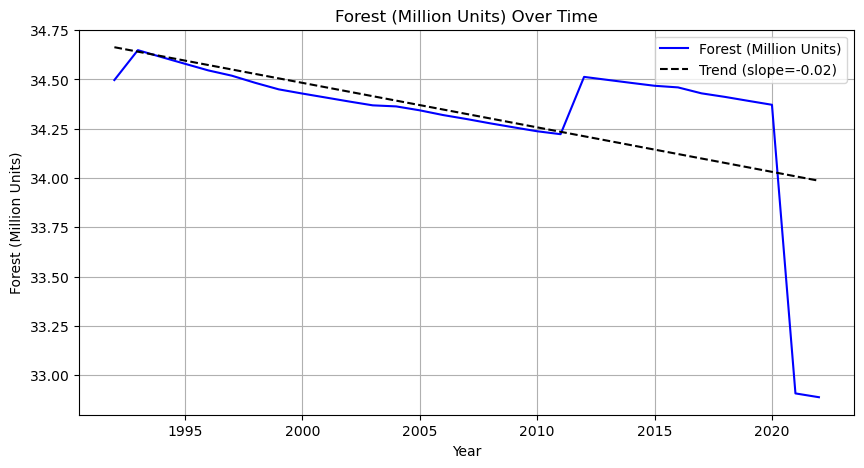

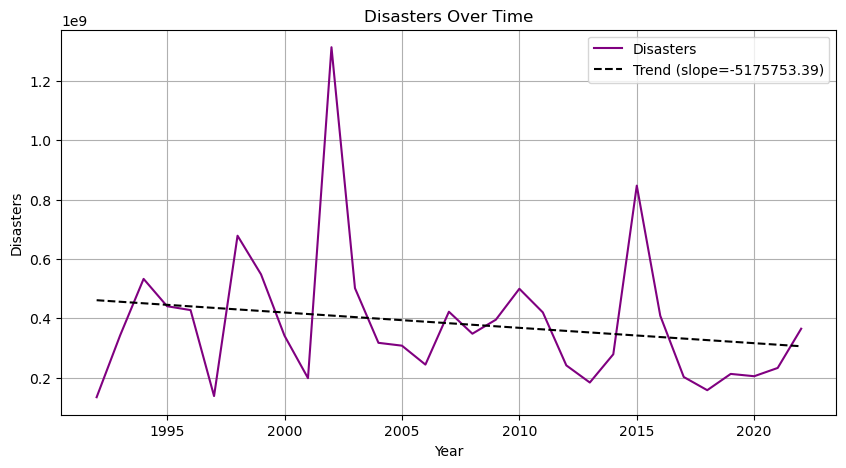

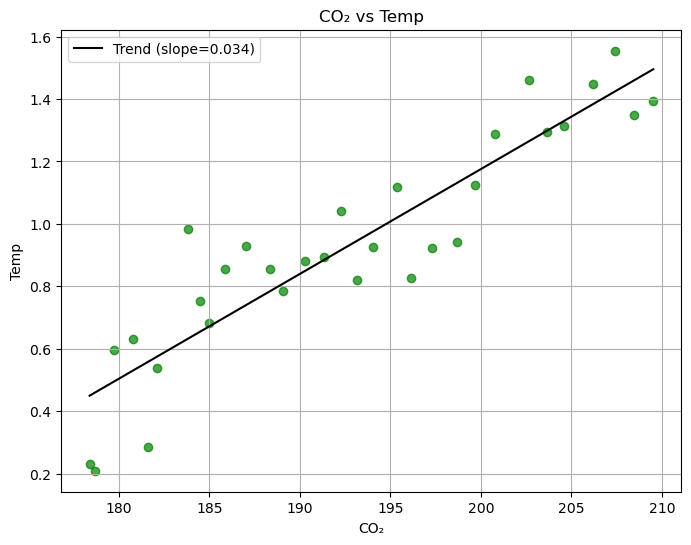

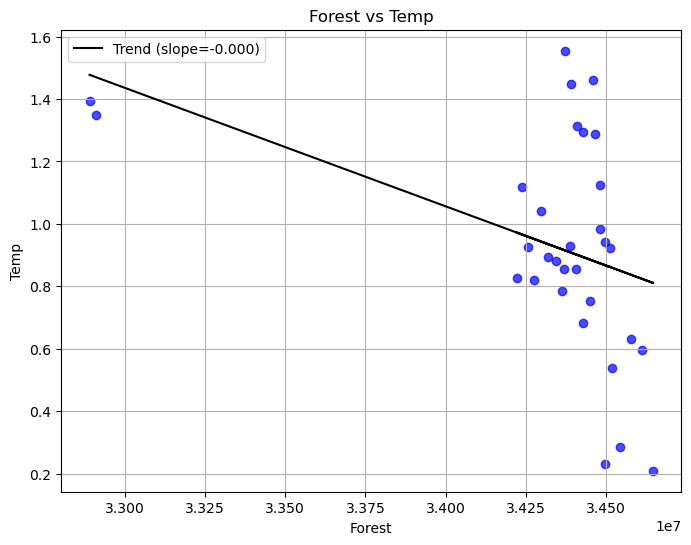

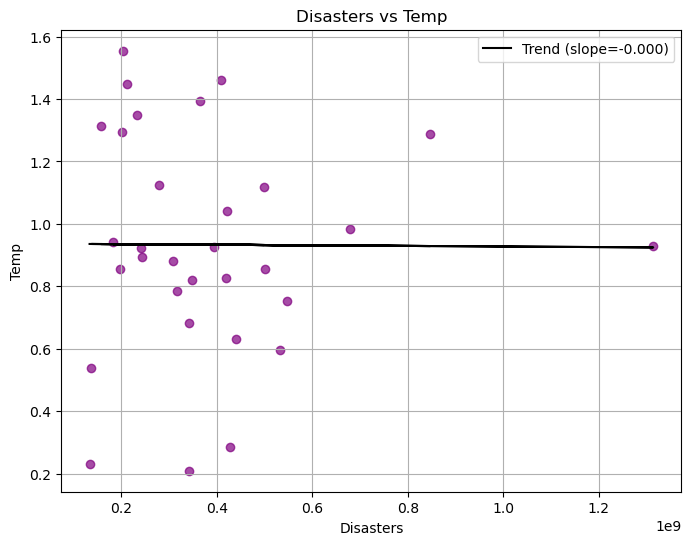

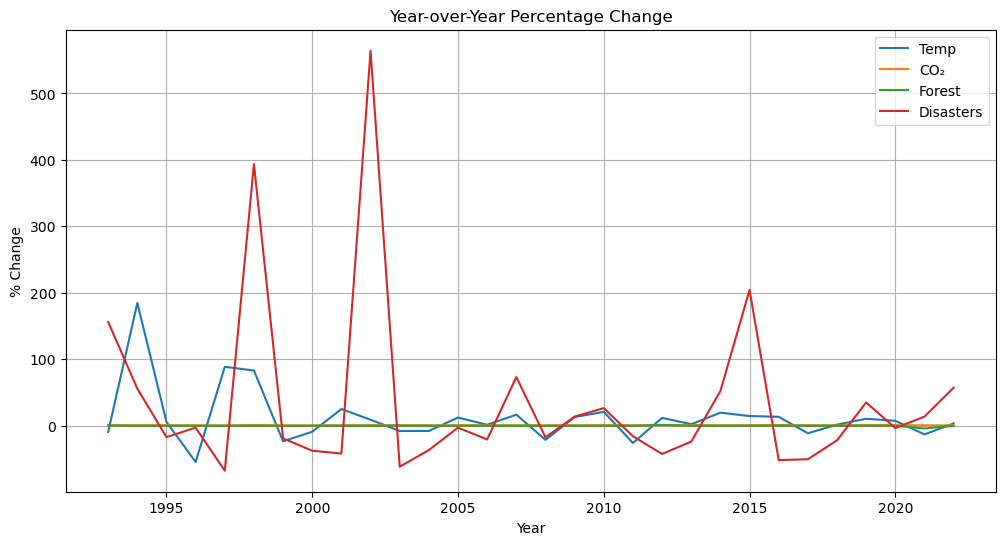

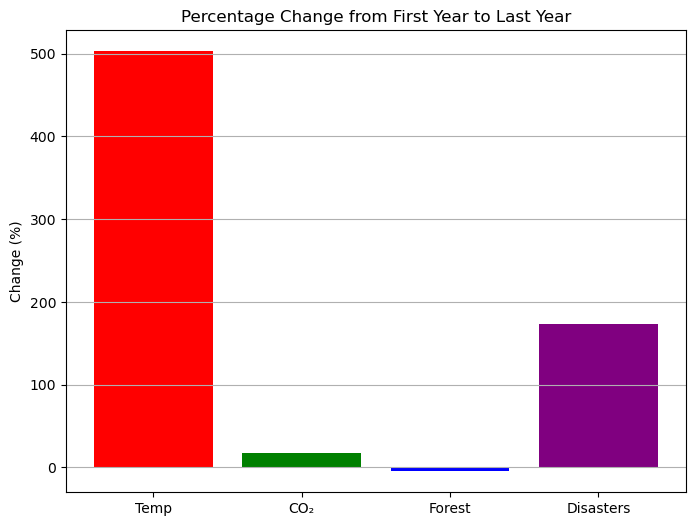

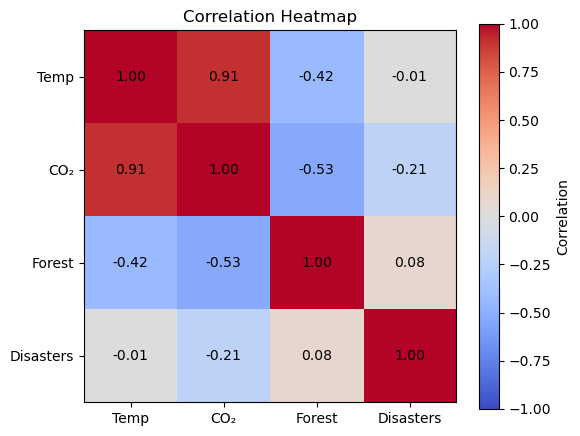

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# ---------------------------
# Helper Function to Read CSV
# ---------------------------
def read_csv(file):
    with open(file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

# ---------------------------
# 1. Temperature Data
# ---------------------------
temp_file = 'Indicator_3_1_Climate_Indicators_Annual_Mean_Global_Surface_Temperature_577579683071085080.csv'
data = read_csv(temp_file)
header, rows = data[0], data[1:]
years_temp = np.array([int(c) for c in header[10:]])
temp_values = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[10:]]
    temp_values.append(vals)
temp_values = np.array(temp_values)
global_temp = np.nanmean(temp_values, axis=0)

# ---------------------------
# 2. CO₂ Data
# ---------------------------
co2_file = 'Indicator_3_2_Climate_Indicators_Monthly_Atmospheric_Carbon_Dioxide_concentrations_-7117330003911643847.csv'
data = read_csv(co2_file)
header, rows = data[0], data[1:]
dates, values_co2 = [], []
for row in rows:
    try:
        dates.append(row[10])
        values_co2.append(float(row[11]))
    except:
        continue
dates = np.array(dates)
values_co2 = np.array(values_co2)
years_co2 = np.array([int(d[:4]) for d in dates])
unique_years_co2 = np.unique(years_co2)
annual_co2 = np.array([values_co2[years_co2 == y].mean() for y in unique_years_co2])

# ---------------------------
# 3. Forest Data
# ---------------------------
forest_file = 'Forest_and_Carbon.csv'
data = read_csv(forest_file)
header, rows = data[0], data[1:]
year_cols = [c for c in header if c.startswith('F')]
years_forest = np.array([int(c[1:]) for c in year_cols])
forest_vals = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[-len(year_cols):]]
    forest_vals.append(vals)
forest_vals = np.array(forest_vals)
global_forest = np.nansum(forest_vals, axis=0)

# ---------------------------
# 4. Disaster Data
# ---------------------------
disaster_file = 'Indicator_11_1_Physical_Risks_Climate_related_disasters_frequency_7212563912390016675.csv'
data = read_csv(disaster_file)
header, rows = data[0], data[1:]
year_cols = [c for c in header if c.strip().isdigit()]
years_disasters = np.array([int(c) for c in year_cols])
disaster_vals = []
for row in rows:
    vals = [float(x) if x else np.nan for x in row[-len(year_cols):]]
    disaster_vals.append(vals)
disaster_vals = np.array(disaster_vals)
global_disasters = np.nansum(disaster_vals, axis=0)

# ---------------------------
# 5. Align Common Years
# ---------------------------
common_years = sorted(list(set(years_temp) & set(unique_years_co2) & set(years_forest) & set(years_disasters)))
common_years = np.array(common_years)

def align_data(years, data, common):
    aligned = []
    for y in common:
        if y in years:
            aligned.append(data[list(years).index(y)])
        else:
            aligned.append(np.nan)
    return np.array(aligned)

temp_common = align_data(years_temp, global_temp, common_years)
co2_common = align_data(unique_years_co2, annual_co2, common_years)
forest_common = align_data(years_forest, global_forest, common_years)
disaster_common = align_data(years_disasters, global_disasters, common_years)

# ---------------------------
# 6. Correlation
# ---------------------------
data_matrix = np.vstack([temp_common, co2_common, forest_common, disaster_common])
corr_matrix = np.corrcoef(data_matrix)

# ---------------------------
# 7. Visualizations
# ---------------------------

# (A) Combined Trend
plt.figure(figsize=(12, 6))
plt.plot(common_years, temp_common, color='red', label='Temp (°C)')
plt.plot(common_years, co2_common, color='green', label='CO₂ (ppm)')
plt.plot(common_years, forest_common / 1e6, color='blue', label='Forest (Million Units)')
plt.plot(common_years, disaster_common, color='purple', label='Disasters')
plt.title("Climate Indicators Over Time (Aligned Years)")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

# (B) Individual Trends with Regression
indicators = [(temp_common, 'Temperature (°C)', 'red'), 
              (co2_common, 'CO₂ (ppm)', 'green'),
              (forest_common / 1e6, 'Forest (Million Units)', 'blue'),
              (disaster_common, 'Disasters', 'purple')]

for data, title, color in indicators:
    plt.figure(figsize=(10, 5))
    plt.plot(common_years, data, color=color, label=title)
    # Trend line
    coeffs = np.polyfit(common_years, data, 1)
    trend = coeffs[1] + coeffs[0]*common_years
    plt.plot(common_years, trend, '--', color='black', label=f"Trend (slope={coeffs[0]:.2f})")
    plt.title(f"{title} Over Time")
    plt.xlabel("Year")
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# (C) Scatter with Regression Lines
pairs = [(co2_common, temp_common, 'CO₂ vs Temp', 'green', 'Temp'),
         (forest_common, temp_common, 'Forest vs Temp', 'blue', 'Temp'),
         (disaster_common, temp_common, 'Disasters vs Temp', 'purple', 'Temp')]

for x, y, title, color, ylabel in pairs:
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color=color, alpha=0.7)
    coeffs = np.polyfit(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], 1)
    line = coeffs[1] + coeffs[0]*x
    plt.plot(x, line, color='black', label=f"Trend (slope={coeffs[0]:.3f})")
    plt.title(title)
    plt.xlabel(title.split(' vs ')[0])
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# (D) Year-over-Year Percentage Change
changes = {
    'Temp': np.diff(temp_common)/temp_common[:-1]*100,
    'CO₂': np.diff(co2_common)/co2_common[:-1]*100,
    'Forest': np.diff(forest_common)/forest_common[:-1]*100,
    'Disasters': np.diff(disaster_common)/disaster_common[:-1]*100
}

plt.figure(figsize=(12, 6))
for key, val in changes.items():
    plt.plot(common_years[1:], val, label=key)
plt.title("Year-over-Year Percentage Change")
plt.xlabel("Year")
plt.ylabel("% Change")
plt.legend()
plt.grid(True)
plt.show()

# (E) First vs Last Year Comparison
first_vals = np.array([temp_common[0], co2_common[0], forest_common[0], disaster_common[0]])
last_vals = np.array([temp_common[-1], co2_common[-1], forest_common[-1], disaster_common[-1]])
pct_change_first_last = ((last_vals - first_vals) / first_vals) * 100

labels = ['Temp', 'CO₂', 'Forest', 'Disasters']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(labels, pct_change_first_last, color=['red', 'green', 'blue', 'purple'])
plt.title("Percentage Change from First Year to Last Year")
plt.ylabel("Change (%)")
plt.grid(axis='y')
plt.show()

# (F) Correlation Heatmap with Color Intensity
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{corr_matrix[i,j]:.2f}", ha='center', va='center', color='black')
plt.xticks(range(4), ['Temp','CO₂','Forest','Disasters'])
plt.yticks(range(4), ['Temp','CO₂','Forest','Disasters'])
plt.title("Correlation Heatmap")
plt.show()
